In [21]:
# 导入必要库
import pandas as pd
import numpy as np  # numpy也是做数据处理比较常用的库，官方文档：https://numpy.org/
import tensorflow as tf  # 我们玩神经网络的库，官方网站：https://tensorflow.google.cn/
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# 读数据
df = pd.read_excel('C:\\Users\\mazhen\\Desktop\\data.xlsx')
df = df[29:].set_index(df['time'][29:]).drop(columns=['time'])  # 设置时间为索引，把含空值的与不必要的列去掉

# 设置训练集、验证集和测试集的比例为7：2：1
n = len(df)
train_split = int(0.7*n)
val_split = int(0.9*n)

df.head()

,open,close,high,low,diff,up,down,avg_up,avg_down,rsi,ema12,ema26,dif,mov_avg_ten,mov_avg_thirty,dea9,macd
time,,,,,,,,,,,,,,,,,
2009-02-20,17.16,17.57,17.58,17.09,0.41,0.41,0.00,0.333333,0.298333,52.770449,17.522988,16.655994,0.866994,17.998,16.206667,1.043946,-0.353905
2009-02-23,17.24,18.09,18.15,16.90,0.52,0.52,0.00,0.316667,0.298333,51.490515,17.610220,16.762217,0.848004,17.931,16.388000,1.004757,-0.313508
2009-02-24,17.69,17.00,17.98,16.93,-1.09,0.00,-1.09,0.173333,0.480000,26.530612,17.516340,16.779830,0.736510,17.750,16.493667,0.951108,-0.429196
2009-02-25,17.23,16.62,17.30,16.18,-0.38,0.00,-0.38,0.173333,0.460000,27.368421,17.378442,16.767991,0.610451,17.601,16.593000,0.882976,-0.545051
2009-02-26,16.64,15.95,17.15,15.63,-0.67,0.00,-0.67,0.173333,0.356667,32.704403,17.158681,16.707399,0.451282,17.460,16.675000,0.796638,-0.690711


In [22]:
df_mean = df[:train_split].mean(axis=0)  # 计算每个特征在训练集的均值备用，axis=0表示计算的是每个特征而不是每日各个特征的均值
df_std = df[:train_split].std(axis=0)  # 计算每个特征在训练集的标准差备用
df = (df - df_mean) / df_std  # 标准化

df = df.values
target = df[:, 1]

print(type(df))  # values后df的类型从DataFrame变成了ndarray，没有head()方法
print(df.shape)  # 计1245条数据，17个特征

<class 'numpy.ndarray'>
(2794, 17)


In [23]:
def window_generator(dataset, target, start_index, end_index, 
                     history_size, target_size):
    
    """
    Generate window for training, validation and testing.
    
    Parameters:
    
        dataset:collection of features; target:collection of labels;

        start_index:beginning of the slice; end_index:end of the slice;

        history_size:input width; target_size:label width.

    """
    
    features = []
    labels = []
    
    if end_index is None:
        end_index = len(dataset) - target_size
    
    start_index += history_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        features.append(dataset[indices])
        labels.append(target[i:i+target_size])
        
    return np.array(features), np.array(labels)

In [24]:
def loss_curve(history):
    
    """
    Plotting the loss curve.
        
    """
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    plt.figure()
    
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

In [25]:
EPOCHS = 100  # 设置最大训练轮数为100轮
EVALUATION_INTERNAL = 120  # step per epoch

# 数据增强参数备用
BATCH_SIZE = 100
BUFFER_SIZE = 2000


def compile_and_fit(model, train_data, val_data, patience=10):
    
    """
    Define the process of compling and fitting the model.
    
    """
    
    # 为防止过拟合，监视验证集上的loss值，在10个epoch内没有发生太大变化则终止训练
    early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=patience,
    mode='auto',
    restore_best_weights=True)  # 返回最优参数，而非训练停止时的参数
    
    # 模型编译
    model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0),  # 设置优化器
                 loss='mae')  # 设置损失函数
    
    # 模型拟合
    history = model.fit(train_data, epochs=EPOCHS,
                        steps_per_epoch=EVALUATION_INTERNAL,
                        validation_steps=50,
                        validation_data=val_data,
                        callbacks=[early_stopping])
    return history
    

In [26]:
X_train_single, y_train_single = window_generator(dataset=df, target=target, start_index=0,
                                                 end_index=train_split, history_size=1, target_size=1)

X_val_single, y_val_single = window_generator(dataset=df, target=target, start_index=train_split,
                                             end_index=val_split, history_size=1, target_size=1)

X_test_single, y_test_single = window_generator(dataset=df, target=target, start_index=val_split,
                                             end_index=n-1, history_size=1, target_size=1)

X_train_multi, y_train_multi = window_generator(dataset=df, target=target, start_index=0,
                                                 end_index=train_split, history_size=5, target_size=1)

X_val_multi, y_val_multi = window_generator(dataset=df, target=target, start_index=train_split,
                                             end_index=val_split, history_size=5, target_size=1)

X_test_multi, y_test_multi = window_generator(dataset=df, target=target, start_index=val_split,
                                              end_index=n-5, history_size=5, target_size=1)

In [27]:
print(X_train_multi.shape)
print(X_val_multi.shape)
print(X_test_multi.shape)

(1950, 5, 17)
(554, 5, 17)
(270, 5, 17)


In [30]:
train_single = tf.data.Dataset.from_tensor_slices((X_train_single, y_train_single))
val_single = tf.data.Dataset.from_tensor_slices((X_val_single, y_val_single))

train_multi = tf.data.Dataset.from_tensor_slices((X_train_multi, y_train_multi))
val_multi = tf.data.Dataset.from_tensor_slices((X_val_multi, y_val_multi))

train_single = train_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()  # 数据增强，shuffle只对训练集做
val_single = val_single.cache().batch(BATCH_SIZE).repeat()  # 数据增强，shuffle只对训练集做

train_multi = train_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()  # 数据增强，shuffle只对训练集做
val_multi = val_multi.cache().batch(BATCH_SIZE).repeat()  # 数据增强，shuffle只对训练集做

In [29]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

In [32]:
linear_history = compile_and_fit(linear, train_single, val_single)

Train for 120 steps, validate for 50 steps
Epoch 1/100
120/120 [==============================] - 0s 4ms/step - loss: 0.0352 - val_loss: 0.0114
Epoch 2/100
120/120 [==============================] - 0s 1ms/step - loss: 0.0350 - val_loss: 0.0100
Epoch 3/100
120/120 [==============================] - 0s 1ms/step - loss: 0.0351 - val_loss: 0.0093
Epoch 4/100
120/120 [==============================] - 0s 1ms/step - loss: 0.0350 - val_loss: 0.0089
Epoch 5/100
120/120 [==============================] - 0s 1ms/step - loss: 0.0350 - val_loss: 0.0090
Epoch 6/100
120/120 [==============================] - 0s 1ms/step - loss: 0.0350 - val_loss: 0.0099
Epoch 7/100
120/120 [==============================] - 0s 1ms/step - loss: 0.0349 - val_loss: 0.0095
Epoch 8/100
120/120 [==============================] - 0s 1ms/step - loss: 0.0350 - val_loss: 0.0086
Epoch 9/100
120/120 [==============================] - 0s 1ms/step - loss: 0.0350 - val_loss: 0.0088
Epoch 10/100
120/120 [==========================

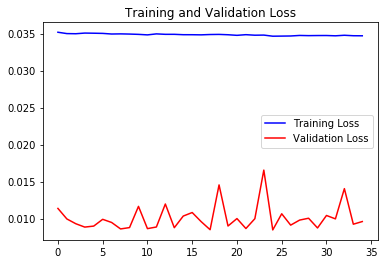

In [33]:
loss_curve(linear_history)

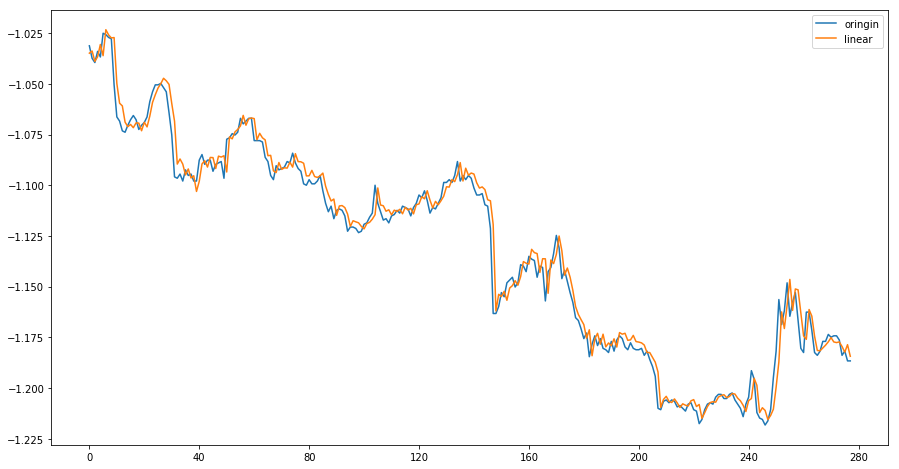

In [34]:
linear_result = linear.predict(X_test_single).reshape(-1,1)

fig = plt.figure(figsize=(15, 8))
ax = plt.subplot2grid((3, 3), (0, 0), rowspan=3, colspan=3)
ax.xaxis.set_major_locator(mticker.MaxNLocator(10))

plt.plot(y_test_single, label='oringin')
plt.plot(linear_result, label='linear')

plt.legend()
plt.show()

In [35]:
single_dense = tf.keras.Sequential([
    tf.keras.layers.Dense(17),
    tf.keras.layers.Dense(4, activation='sigmoid'),
    tf.keras.layers.Dense(1)
])

single_dense_history = compile_and_fit(single_dense, train_single, val_single)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Train for 120 steps, validate for 50 steps
Epoch 1/100
120/120 [==============================] - 1s 7ms/step - loss: 0.2973 - val_loss: 0.0166
Epoch 2/100
120/120 [==============================] - 0s 2ms/step - loss: 0.0955 - val_loss: 0.0210
Epoch 3/100
120/120 [==============================] - 0s 2ms/step - loss: 0.0723 - val_loss: 0.0253
Epoch 4/100
120/120 [==============================] - 0s 2ms/step - loss: 0.0617 - val_loss: 0.0187
Epoch 5/100
120/120 [==============================] - 0s 2ms

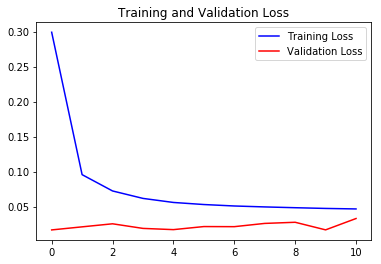

In [36]:
loss_curve(single_dense_history)

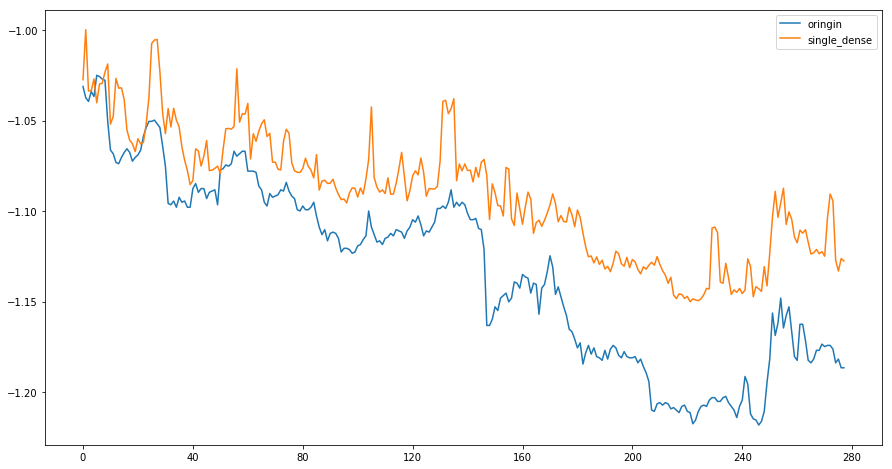

In [37]:
single_result = single_dense.predict(X_test_single).reshape(-1, 1)

fig = plt.figure(figsize=(15, 8))
ax = plt.subplot2grid((3, 3), (0, 0), rowspan=3, colspan=3)
ax.xaxis.set_major_locator(mticker.MaxNLocator(10))

plt.plot(y_test_single, label='oringin')
plt.plot(single_result, label='single_dense')
plt.legend()

plt.show()

In [38]:
lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(17),
    tf.keras.layers.Dense(1)
])

lstm_history = compile_and_fit(lstm, train_multi, val_multi)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Train for 120 steps, validate for 50 steps
Epoch 1/100
120/120 [==============================] - 2s 20ms/step - loss: 0.3039 - val_loss: 0.0593
Epoch 2/100
120/120 [==============================] - 1s 4ms/step - loss: 0.0582 - val_loss: 0.0158
Epoch 3/100
120/120 [==============================] - 1s 4ms/step - loss: 0.0472 - val_loss: 0.0185
Epoch 4/100
120/120 [==============================] - 0s 4ms/step - loss: 0.0437 - val_loss: 0.0132
Epoch 5/100
120/120 [==============================] - 1s 5m

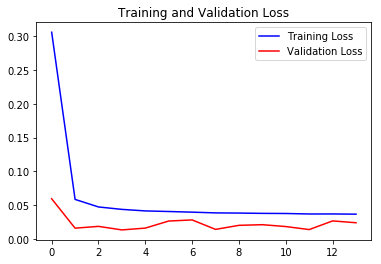

In [39]:
loss_curve(lstm_history)

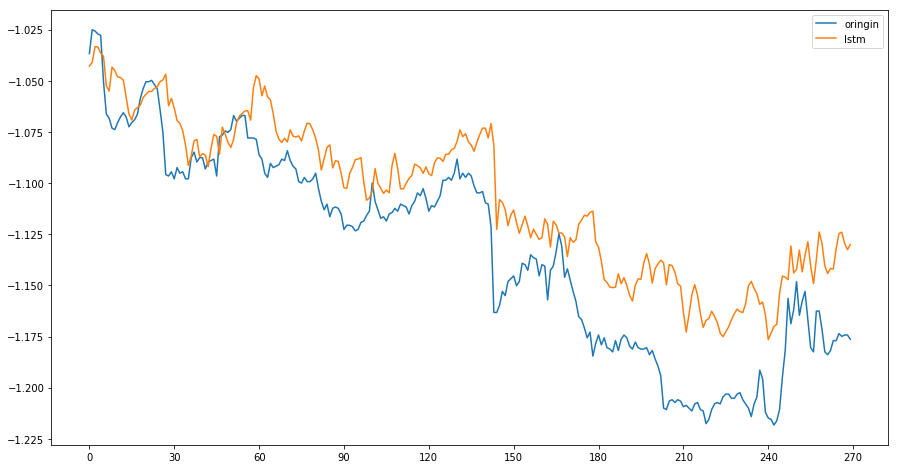

In [40]:
lstm_result = lstm.predict(X_test_multi).reshape(-1, 1)

fig = plt.figure(figsize=(15, 8))
ax = plt.subplot2grid((3, 3), (0, 0), rowspan=3, colspan=3)
ax.xaxis.set_major_locator(mticker.MaxNLocator(10))

plt.plot(y_test_multi, label='oringin')
plt.plot(lstm_result, label='lstm')
plt.legend()

plt.show()